# Intercomparison Campaigns - Requesting Data

**Contains modified Copernicus Climate Change Service Information 2020**
under [License](https://apps.ecmwf.int/datasets/licences/copernicus/)

*Copernicus Climate Change Service (C3S) - Upper Air Data Service (2020)*

The purpose of this IPython Notebook is to demonstrate the access and usability of data from intercomparison campaigns. Example usage of the Climate Data Store (CDS) Frontend for Radiosonde data.

    Author: M. Blaschek
    Date: 09.2020
    Contact: michael.blaschek [at] univie.ac.at
    License: C3S, 2020


In [1]:
# %pylab inline

In [2]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import cdsapi, zipfile, os, time
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning) # just cosmetics

# Please note: Server URL will be omitted, once published
c = cdsapi.Client(url='https://sis-dev.climate.copernicus.eu/api/v2')

## Request soundings from an intercomparison campaign

We choose the following intercomparison campaign:

    WMO International radiosonde comparison, Tsukuba, Japan, 15.Feb to 12. Mar. 1993

    INSTRUMENTS and OBSERVING METHODS REPORT No. 59

The request for the intercomparison data looks exactly the same as for all the other data requests. In order to retrieve the data station IDs need to be given:
* `0-20100-0-01802`, Type: `VHN` ( Vaisala RS80-15N or RS80-15NA radiosonde )
* `0-20100-0-01803`, Type: `VHl` ( Vaisala RS80-15LH H-Humicap LoRAN radiosonde )
* `0-20100-0-01804`, Type: `J8H` ( Japan Meisei RSII-80 or RS2-80 high-resolution radiosonde )
* `0-20100-0-01805`, Type: `J93` ( Japan Meisei RSII-91 radiosonde, SiO type 93 uncoated thermistor )

We request a csv file and read the data with `pandas`.

In [9]:
t0 = time.time()
# Start Request
r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
               {
                   'variable': ["air_temperature"],
                   'statid': ['0-20100-0-01802','0-20100-0-01803', '0-20100-0-01804', '0-20100-0-01805', '0-20100-0-01807'],
                   'period': '19000101/20201231',
                   'optional': ['sonde_type'],
                   #'format': 'csv'                   
               })

if True:
    # Start Download
    r.download(target='download.zip')
    # Check file size
    assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
    # Unzip the Data Stream
    z = zipfile.ZipFile('download.zip')
    print("Unzipping retrieved files: to ./exampla_data/1")
    print(z.namelist())
    z.extractall(path='./example_data/1')
    z.close()
    os.remove('download.zip')
    print("Time elapsed: ", time.time()-t0, "s")

2021-06-21 13:41:24,294 INFO Welcome to the CDS
2021-06-21 13:41:24,295 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-06-21 13:41:24,526 INFO Request is queued
2021-06-21 13:41:25,563 INFO Request is completed
2021-06-21 13:41:25,601 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1624275685.1674156-9859-4-2d35bf4e-76ae-409c-aae8-d4cf76b0bf89.zip to download.zip (559.5K)
2021-06-21 13:41:25,918 INFO Download rate 1.7M/s 


Unzipping retrieved files: to ./exampla_data/1
['dest_0-20100-0-01802_air_temperature.nc', 'dest_0-20100-0-01803_air_temperature.nc', 'dest_0-20100-0-01804_air_temperature.nc', 'dest_0-20100-0-01805_air_temperature.nc', 'dest_0-20100-0-01807_air_temperature.nc']
Time elapsed:  1.82778000831604 s


---
## Read data

In [4]:
import pandas as pd
pd.set_option('display.width',200, 'display.max_rows',50)
data = pd.read_csv('example_data/1/temperature.csv', index_col=0)
sondestypes = dict(zip(['0-20100-0-01802','0-20100-0-01803', '0-20100-0-01804', '0-20100-0-01805'],['VHN', 'VHl', 'J8H', 'J93']))

In [10]:
display(data)

,lat,lon,plev,report_id,sonde_type,ta,time,trajectory_label,ta_units,plev_units,statindex
obs_id,,,,,,,,,,,
0,36.05,140.13,2900.0,0-20100-0-01802-001,VHN,216.75,1993-02-18 01:09:40,nnnnnnnnnnnnnnnnnnn,K,Pa,0
1,36.05,140.13,3010.0,0-20100-0-01802-001,VHN,215.65,1993-02-18 01:08:40,nnnnnnnnnnnnnnnnnnn,K,Pa,0
2,36.05,140.13,3170.0,0-20100-0-01802-001,VHN,216.75,1993-02-18 01:07:40,nnnnnnnnnnnnnnnnnnn,K,Pa,0
3,36.05,140.13,3300.0,0-20100-0-01802-001,VHN,216.45,1993-02-18 01:06:40,nnnnnnnnnnnnnnnnnnn,K,Pa,0
4,36.05,140.13,3440.0,0-20100-0-01802-001,VHN,216.45,1993-02-18 01:05:40,nnnnnnnnnnnnnnnnnnn,K,Pa,0
...,...,...,...,...,...,...,...,...,...,...,...
26539,36.05,140.13,89890.0,0-20100-0-01807-060,"Z_M,Z_m,ZM_",273.75,1993-03-11 11:34:21,nnnnnnnnnnnnnnnnnnn,K,Pa,4
26540,36.05,140.13,92880.0,0-20100-0-01807-060,"Z_M,Z_m,ZM_",275.55,1993-03-11 11:33:21,nnnnnnnnnnnnnnnnnnn,K,Pa,4
26541,36.05,140.13,95970.0,0-20100-0-01807-060,"Z_M,Z_m,ZM_",277.15,1993-03-11 11:32:21,nnnnnnnnnnnnnnnnnnn,K,Pa,4


### Observation Periods (IOP) for the intercomparison campaign

In [13]:
# Every Row is an IOP
with pd.option_context('display.max_rows',None):
    print(data.groupby(data['report_id'].str.split('-', expand=True)[4]).count()['ta'])

4
001    553
002    322
003    334
004    291
005    340
006    412
007    395
008    533
009    460
010    458
011    384
012    520
013    497
014    424
015    550
016    411
017    398
018    547
019    370
020    468
021    442
022    361
023    480
024    503
025    392
026    388
027    565
028    489
029    394
030    579
031    260
032    482
033    570
034    405
035    461
036    521
037    396
038    403
039    454
040    385
041    468
042    547
043    375
044    413
045    563
046    338
047    536
048    459
049    413
050    483
051    545
052    409
053    413
054    555
055    290
056    294
057    407
058    576
059    315
060    544
Name: ta, dtype: int64


---
## IOP 002 - 17.Feb 1993

In [25]:
ascent = '-002'
#
# extract following data from each sensor of ascent #002:
# temperature, pressure and datetime
#
temperature = []
pressure = []
datetime = []
for i in ['0-20100-0-01802','0-20100-0-01803', '0-20100-0-01804', '0-20100-0-01805', '0-20100-0-01807']:
    print('statid: ' + str(i))
    buffer = data[data.report_id == i + ascent]
    print('trajectory_label: ' + i + ascent, '#', buffer.shape[0])
    temperature.append(np.array(buffer.ta))
    pressure.append(np.array(buffer.plev))
    datetime.append(np.array(buffer.time))
#    
# get the time into the right shape for later plotting:
# minutes after the ascent start
#
for j in range(len(datetime)):
    for i in range(len(datetime[j])):
        if(i == 0):
            datezero = pd.to_datetime(datetime[j][0])
        datetime[j][i] = (datezero - pd.to_datetime(datetime[j][i]))/np.timedelta64(1,'m')  # convert to minutes

statid: 0-20100-0-01802
trajectory_label: 0-20100-0-01802-002 # 81
statid: 0-20100-0-01803
trajectory_label: 0-20100-0-01803-002 # 81
statid: 0-20100-0-01804
trajectory_label: 0-20100-0-01804-002 # 79
statid: 0-20100-0-01805
trajectory_label: 0-20100-0-01805-002 # 81
statid: 0-20100-0-01807
trajectory_label: 0-20100-0-01807-002 # 0


---
### Plotting of the profiles

In [26]:
# plot settings:
#
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

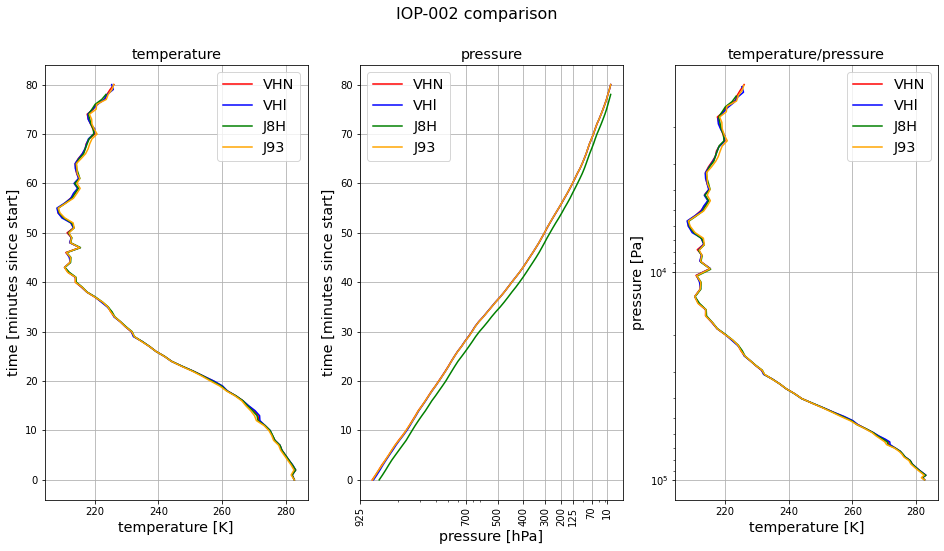

In [27]:
import matplotlib
import matplotlib.pyplot as plt
yplevs = np.flip(np.array([10,70,125,200,300,400,500,700,925])*100.)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
#
# Plotting temperature over time:
#
ax1.plot(temperature[0], np.flip(datetime[0]), c='red')
ax1.plot(temperature[1], np.flip(datetime[1]), c='blue')
ax1.plot(temperature[2], np.flip(datetime[2]), c='green')
ax1.plot(temperature[3], np.flip(datetime[3]), c='orange')
ax1.set(xlabel='temperature [K]', ylabel ='time [minutes since start]', title='temperature')
ax1.legend(sondestypes.values(), loc='best')
# ax1.invert_yaxis()
ax1.grid()
#
# Plotting pressure over time:
#
ax2.semilogx(pressure[0], datetime[0], c='red')
ax2.semilogx(pressure[1], datetime[1], c='blue')
ax2.semilogx(pressure[2], datetime[2], c='green')
ax2.semilogx(pressure[3], datetime[3], c='orange')
ax2.set(xlabel='pressure [hPa]', ylabel ='time [minutes since start]', title='pressure')
ax2.legend(sondestypes.values(), loc='best')
ax2.set_xticks(ticks=yplevs)
ax2.set_xticklabels(map("{:.0f}".format,yplevs[::-1]/100),rotation='vertical')
ax2.grid()
#
# Plotting pressure over temperature:
#
ax3.semilogy(temperature[0], (pressure[0]), c='red')
ax3.semilogy(temperature[1], (pressure[1]), c='blue')
ax3.semilogy(temperature[2], (pressure[2]), c='green')
ax3.semilogy(temperature[3], (pressure[3]), c='orange')
ax3.set(xlabel ='temperature [K]', ylabel='pressure [Pa]', title='temperature/pressure')
ax3.legend(sondestypes.values(), loc='best')
ax3.invert_yaxis()
ax3.grid()
#     -
fig.suptitle('IOP'+ascent+' comparison', fontsize=16)
plt.show()
plt.close(fig)

### Conclusion:
We can see an offset from one sonde's pressure data. The logged pressure is fairly compliant to the other sondes regarding temperature, so it is unlikely that the a barometer is wrong. The J8H sonde seems to have a complications with its time module.

---
## Plot the pressure differences to the first sonde

In [28]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

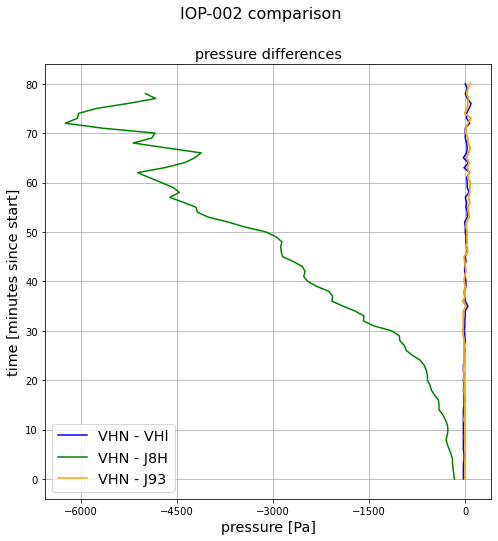

<Figure size 576x576 with 0 Axes>

In [29]:
fig, (ax1) = plt.subplots(1)
#
# Plotting pressur differences over time:
# pressure[0] is the longest data, so it will be shortened to the length of the comparison counterpart
#
ax1.plot(pressure[0][:len(pressure[1])] - pressure[1], datetime[1][:len(pressure[1])], c='blue')
ax1.plot(pressure[0][:len(pressure[2])] - pressure[2], datetime[2][:len(pressure[2])], c='green')
ax1.plot(pressure[0][:len(pressure[3])] - pressure[3], datetime[3][:len(pressure[3])], c='orange')
ax1.plot(pressure[0] - pressure[3], datetime[0], c='orange')
ax1.set(xlabel='pressure [Pa]', ylabel ='time [minutes since start]', title='pressure differences')
['VHN', 'VHl', 'J8H', 'J93']
ax1.legend(['VHN - VHl', 'VHN - J8H', 'VHN - J93'], loc='best')
ax1.xaxis.set_major_locator(plt.MaxNLocator(6))
ax1.grid()
#
fig.suptitle('IOP'+ascent+' comparison', fontsize=16)
plt.figure(figsize=(8, 8))
plt.show()
plt.close(fig)

## Interpolating pressure data for sonde comparison:

### Interpolate the sonde pressure from one reference sonde to all the other sonds:

There is no height information, so the interpolation hast do be done over the time data.

This is a viable solution since all sensors were mounted on the same weather balloon and were at the exact same height all the time.

In [30]:
import os
from scipy.interpolate import interp1d
import sys

In [31]:
# Easy interpolation with SciPy:
# forward interpolation pressure on time:
#
f = interp1d( np.log(np.array(pressure[0])), np.array(datetime[0]))

#
# for any number of pressure levels:
#
pressure_list = [75000., 50000., 25000.] # Pa
pres_delta = []
for j in range(len(pressure_list)):
    print('Time at '+str(pressure_list[j])+' Pa: ' + str(f(np.log(pressure_list[j]))))
    pres_delta.append([])
    for i in range(len(pressure)):
        #
        # backward interpolation time on pressure:
        #
        try:
            g = interp1d( np.array(datetime[i]), np.log(np.array(pressure[i])))
            print('measured pressure at this time - sonde '+str(i+1)+': ' + str(np.exp(float((g(f(np.log(pressure_list[j]))))))) + ' Pa')
            pres_delta[j].append(pressure_list[j] - np.exp(float((g(f(np.log(pressure_list[j])))))))
            print('delta pressure sonde 1 - '+str(i+1)+': ' + str(pressure_list[j] - np.exp(float((g(f(np.log(pressure_list[j])))))))+ ' Pa')
        except:
            pass
    print('---')

Time at 75000.0 Pa: 71.10149344512143
measured pressure at this time - sonde 1: 74999.99999999996 Pa
delta pressure sonde 1 - 1: 4.3655745685100555e-11 Pa
measured pressure at this time - sonde 2: 74993.0995776619 Pa
delta pressure sonde 1 - 2: 6.9004223381052725 Pa
measured pressure at this time - sonde 3: 80717.34745272146 Pa
delta pressure sonde 1 - 3: -5717.347452721457 Pa
measured pressure at this time - sonde 4: 74987.04288654937 Pa
delta pressure sonde 1 - 4: 12.957113450625911 Pa
---
Time at 50000.0 Pa: 60.285290385734285
measured pressure at this time - sonde 1: 50000.00000000001 Pa
delta pressure sonde 1 - 1: -7.275957614183426e-12 Pa
measured pressure at this time - sonde 2: 49972.7558558601 Pa
delta pressure sonde 1 - 2: 27.244144139898708 Pa
measured pressure at this time - sonde 3: 54793.461312091626 Pa
delta pressure sonde 1 - 3: -4793.461312091626 Pa
measured pressure at this time - sonde 4: 49931.029023466115 Pa
delta pressure sonde 1 - 4: 68.97097653388482 Pa
---
Time

In [32]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (18, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

[Text(0.5, 0, 'sensor'),
 Text(0, 0.5, 'pressure difference [Pa]'),
 Text(0.5, 1.0, '25000 Pa')]

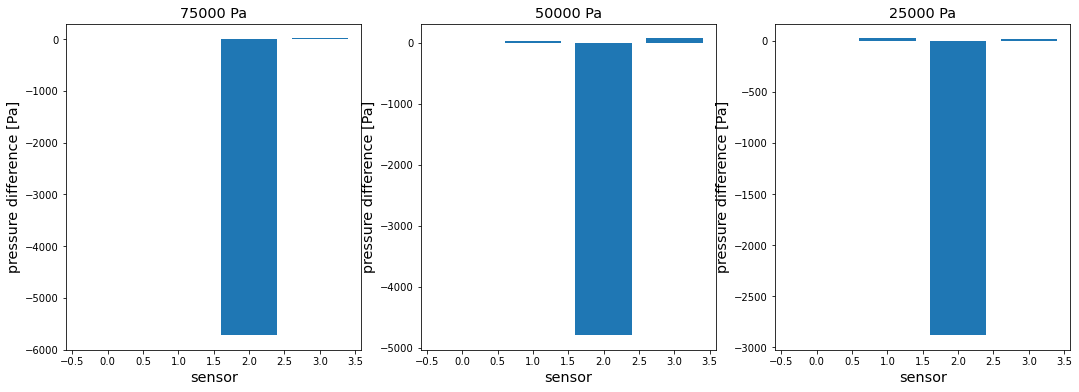

In [33]:
#
# create barplot for all the differences on different levels
#
np.arange(len(pres_delta))
#
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.bar(np.arange(len(pres_delta[0])),(pres_delta[0]))
ax1.set(xlabel ='sensor', ylabel='pressure difference [Pa]', title='75000 Pa')
ax2.bar(np.arange(len(pres_delta[1])),(pres_delta[1]))
ax2.set(xlabel ='sensor', ylabel='pressure difference [Pa]', title='50000 Pa')
ax3.bar(np.arange(len(pres_delta[2])),(pres_delta[2]))
ax3.set(xlabel ='sensor', ylabel='pressure difference [Pa]', title='25000 Pa')
